# Import Modules

In [35]:
import os
import pandas as pd
import numpy as np
import scipy.optimize as sc 
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image
from datetime import datetime as dt 

# Data Preprocessing

In [26]:
# Import data from files
os.chdir('/Users/talhajamal/Desktop/Code/BigData1Project')
data = pd.read_csv("data/Returns_Data.csv")
data['date'] = pd.to_datetime(data['date'], dayfirst=False)
characteristics = pd.read_csv("data/Stock_Characteristics_Data.csv")
dictionary = pd.read_excel("data/StockDataDictionary.xlsx")

# Create new dataframes
prices = data.pivot(index='date', columns='ticker', values='PRC')
volume = data.pivot(index='date', columns='ticker', values='VOL')
returns = data.pivot(index='date', columns='ticker', values='RET')
#returns = returns * 100 # Scale returns to percentage
# Summary of Returns
returns_summary = returns.describe()
shares_outstanding = data.pivot(index='date', columns='ticker', values='SHROUT')
value_weighted_returns = data.pivot(index='date', columns='ticker', values='vwretd')
equal_weighted_returns = data.pivot(index='date', columns='ticker', values='ewretd')
tickers = prices.columns # List of Tickers

# Functions

In [48]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    """ Calculate Portfolio Performance"""
    annualizedReturns = np.sum(meanReturns*weights)*252
    annualizedStd = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(252)
    return annualizedReturns*100, annualizedStd*100

def portfolioVariance(weights, meanReturns, covMatrix):
    """ Return Portfolio Variance """
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]

def portfolioReturn(weights, meanReturns, covMatrix):
    """ Return Portfolio Return """
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]

def negativeSR(weights, meanReturns, covMatrix,riskFreeRate = 0):
    """ Calculate Negative Sharpe so that Optimizer works on it and minimizes it -> essentially maximising it"""
    annualizedRet, annualizedStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - ((annualizedRet - riskFreeRate)/annualizedStd)

def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0, 1)):
    """ Minimize the negative Sharpe Ratio -> Maximize it"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1 }) # Weights must sum up to 1
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets)) # For every asset have this bound
    result = sc.minimize(negativeSR, x0=numAssets*[1./numAssets], args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def minimizeVariance(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0, 1)):
    """ Minimize the portfolio variance by altering the weights/allocations of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1 }) # Weights must sum up to 1
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets)) # For every asset have this bound
    result = sc.minimize(portfolioVariance, x0=numAssets*[1./numAssets], args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def meanVarianceOptimiser(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """ For each return target, optimize the portfolio for minimum variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq', 'fun':lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                   {'type':'eq','fun': lambda x: np.sum(x) - 1 }
                   )
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    optimizedResults = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, 
                                   method='SLSQP', constraints=constraints, bounds=bounds)
    return optimizedResults

def eqWeightPortfolioPerformance(meanReturns, covMatrix, returns):
    """ Return the Performance of an Equally Weighted Portfolio"""
    weights = np.array([1/100 for _ in returns])
    equalWeightedPortfolioReturns, equalWeightedPortfolioVolatility = portfolioPerformance(weights, meanReturns, covMatrix)
    equalWeightedPortfolioSR = (-1) * negativeSR(weights, meanReturns, covMatrix)
    print(f"Equal Weighted Portfolio Returns: {round(equalWeightedPortfolioReturns, 2)} %")
    print(f"Equal Weighted Portfolio Volatility: {round(equalWeightedPortfolioVolatility, 2)} %")
    print(f"Equal Weighted Portfolio SR: {round(equalWeightedPortfolioSR, 2)}")
    return equalWeightedPortfolioReturns, equalWeightedPortfolioVolatility, equalWeightedPortfolioSR
    
def maxSRPortfolioPerformance(meanReturns, covMatrix):
    """ Return the Performance of the Maximum SR Portfolio"""
    maxSRPortfolioPerformance = maxSR(meanReturns, covMatrix)
    maxSRPortfolioWeights = maxSRPortfolioPerformance.x
    maxSRPortfolioReturns, maxSRPortfolioVolatility = portfolioPerformance(maxSRPortfolioWeights, meanReturns, covMatrix)
    maxSRPortfolioSR = maxSRPortfolioPerformance.fun * (-1)
    print(f"Max SR Portfolio Returns: {round(maxSRPortfolioReturns, 2)} %")
    print(f"Max SR Portfolio Volatility: {round(maxSRPortfolioVolatility, 2)} %")
    print(f"Max SR Portfolio SR: {round(maxSRPortfolioSR, 2)}")
    return maxSRPortfolioReturns, maxSRPortfolioVolatility, maxSRPortfolioSR, maxSRPortfolioWeights

def minVariancePortfolioPerformance(meanReturns, covMatrix):
    """ Return the Performance of the Minimum Variance Portfolio"""
    minVariancePortfolioPerformance = minimizeVariance(meanReturns, covMatrix)
    minVariancePortfolioWeights = minVariancePortfolioPerformance.x
    minVariancePortfolioReturns, minVariancePortfolioVolatility = portfolioPerformance(minVariancePortfolioWeights, meanReturns, covMatrix)
    minVariancePortfolioSR = (-1) * negativeSR(minVariancePortfolioWeights, meanReturns, covMatrix)
    print(f"Min Variance Portfolio Returns: {round(minVariancePortfolioReturns, 2)} %")
    print(f"Min Variance Portfolio Volatility: {round(minVariancePortfolioVolatility, 2)} %")
    print(f"Min Variance Portfolio SR: {round(minVariancePortfolioSR, 2)}")
    return minVariancePortfolioReturns, minVariancePortfolioVolatility, minVariancePortfolioSR, minVariancePortfolioWeights

def EF_generator(minVariancePortfolioReturns, maxSRPortfolioReturns, meanReturns, covMatrix):
    """ Generate the List for the Efficient Frontier"""
    targetReturns = np.linspace(minVariancePortfolioReturns, maxSRPortfolioReturns, 20)
    efficientFrontier = []
    for target in targetReturns:
        efficientFrontier.append(meanVarianceOptimiser(meanReturns, covMatrix, returnTarget=target)['fun'])
    return efficientFrontier, targetReturns

def EF_graph(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0, 1)):
    """ Return a Graph plotting the min vol, max sr, and efficient frontier"""
    
    maxSRPortfolioRet, maxSRPortfolioVol, maxSRPortfolioSR, maxSRPortfolioWeights = maxSRPortfolioPerformance(meanReturns, covMatrix)
    minVarPortfolioRet, minVarPortfolioVol, minVarPortfolioSR, minVariancePortfolioWeights = minVariancePortfolioPerformance(meanReturns, covMatrix)

    efficientList, targetReturns = EF_generator(minVarPortfolioRet, maxSRPortfolioRet, meanReturns, covMatrix)

    # Plot the Equal Weighted Portfolio
    eqWRet, eqWVol, eqWSR = eqWeightPortfolioPerformance(meanReturns, covMatrix, returns)
    eqWeightedPortfolio = go.Scatter(
        name='Equally Weighted Portfolio',
        mode = 'markers',
        x = [eqWVol],
        y = [eqWRet],
        marker = dict(color='yellow', size=14, line=dict(width=3, color='black') )
    )

    # Plot the Max SR
    MaxSharpeRatio = go.Scatter(
        name='Max Sharpe Ratio',
        mode='markers',
        x = [maxSRPortfolioVol],
        y = [maxSRPortfolioRet],
        marker = dict(color='red', size=14, line=dict(width=3, color='black') )
    )

    # Plot the Min vol
    MinVol = go.Scatter(
        name='Min Volatility',
        mode='markers',
        x = [minVarPortfolioVol],
        y = [minVarPortfolioRet],
        marker = dict(color='green', size=14, line=dict(width=3, color='black') )
    )

    # Plot the Efficient Frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x = [round(ef_std, 2) for ef_std in efficientList],
        y = [round(target, 2) for target in targetReturns],
        line = dict(color='black', width=4, dash='dashdot')
    )

    data = [MaxSharpeRatio, MinVol, eqWeightedPortfolio, EF_curve]
    
    layout = go.Layout(
        title = {
            'text':'Comparison of Portfolios via Mean Variance Optimization',
            'y':0.9,
            'x':0.5,
            'xanchor':'center',
            'yanchor':'top'
        },
        yaxis = dict(title='Annualized Returns (%)'),
        xaxis= dict(title='Annualized Volatility (%)'),
        showlegend= True,
        legend= dict(
                    #x=0.7, 
                    #y=0, 
                    traceorder='normal', 
                    bgcolor='#E2E2E2', 
                    bordercolor='black', 
                    borderwidth=2),
        width=800,
        height=600)
    
    fig = go.Figure(data=data, layout=layout)

    pio.write_image(fig, 'MeanVariancePortfolioOptimization.png')

    return fig.show()

# Mean Returns and CovMatrix

In [49]:
slice_date = dt(year=2018, month=1, day=1)
train = returns.loc[:slice_date]
test = returns.loc[slice_date:]

In [50]:
meanReturns = test.mean()
covMatrix = test.cov()

# Equal Weighted Portfolio

In [51]:
equalWeightedPortfolioRet, equalWeightedPortfolioVol, equalWeightedPortfolioSR = eqWeightPortfolioPerformance(meanReturns, 
                                                                                                              covMatrix, 
                                                                                                              returns)

Equal Weighted Portfolio Returns: 12.68 %
Equal Weighted Portfolio Volatility: 25.34 %
Equal Weighted Portfolio SR: 0.5


# Max SR Portfolio

In [52]:
maxSRPortfolioRet, maxSRPortfolioVol, maxSRPortfolioSR, maxSRPortfolioWeights = maxSRPortfolioPerformance(meanReturns, covMatrix)

Max SR Portfolio Returns: 35.35 %
Max SR Portfolio Volatility: 22.27 %
Max SR Portfolio SR: 1.59


# Min Variance Portfolio

In [53]:
minVarPortfolioRet, minVarPortfolioVol, minVarPortfolioSR, minVariancePortfolioWeights = minVariancePortfolioPerformance(meanReturns, covMatrix)

Min Variance Portfolio Returns: 11.1 %
Min Variance Portfolio Volatility: 16.22 %
Min Variance Portfolio SR: 0.68


# Efficient Frontier

In [54]:
EF_graph(meanReturns, covMatrix)

Max SR Portfolio Returns: 35.35 %
Max SR Portfolio Volatility: 22.27 %
Max SR Portfolio SR: 1.59
Min Variance Portfolio Returns: 11.1 %
Min Variance Portfolio Volatility: 16.22 %
Min Variance Portfolio SR: 0.68
Equal Weighted Portfolio Returns: 12.68 %
Equal Weighted Portfolio Volatility: 25.34 %
Equal Weighted Portfolio SR: 0.5


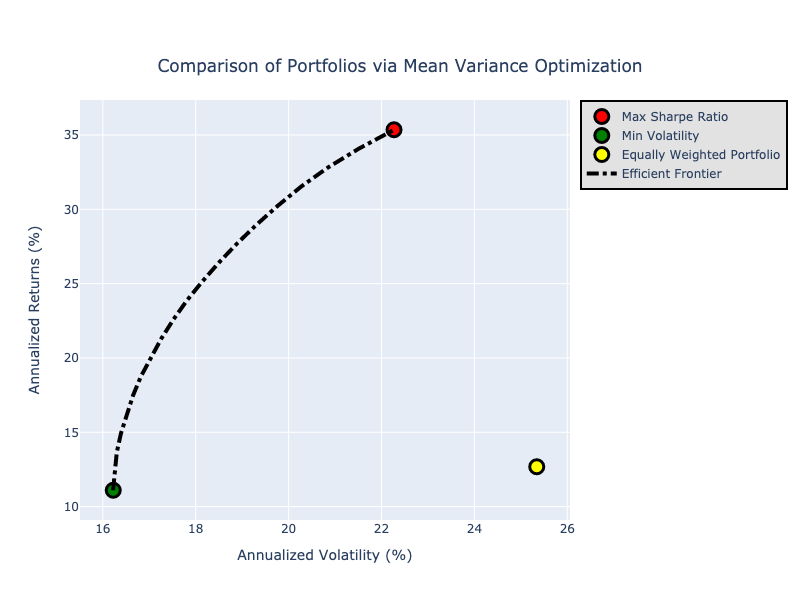

In [55]:
# Display the PNG image file
Image(filename='MeanVariancePortfolioOptimization.png')